In [128]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display, clear_output
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D  

In [129]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [130]:
# wiki page: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation


In [131]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)  # 5*5 from image dimension
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50,1)
        # self.optimizer = torch.optim.Adam(self.parameters(),lr=1e-5)
        # self.sigma = 1
        self.sigma = 0
        # self.r = 1
        self.r = 0
        self.K = 0.25
        self.nt = 75
        self.nS = 75
        t = np.linspace(0,1,self.nt,endpoint=True)
        S = np.linspace(0,1,self.nS,endpoint=True)
        self.tt,self.SS = np.meshgrid(t,S)
        tInput = self.tt.reshape(-1,1)
        SInput = self.SS.reshape(-1,1)
        self.plotX = torch.tensor(np.concatenate((tInput,SInput),axis=1),dtype=torch.float32).to(device)
        self.epochs = 0
        self.losshist = []


    def train(self,x,iterations,lr=1e-5):
        self.optimizer = torch.optim.Adam(self.parameters(),lr=lr)
        itend = self.epochs+iterations
        nplots = 20
        plotEpoch = iterations/nplots
        while self.epochs < itend:
            self.epochs += 1
            y = self.forward(x)
            y = self.applyBoundary(x,y)
            loss = self.lossFunction(x,y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            self.losshist.append(loss.item())
            if self.epochs % plotEpoch == 0:
                clear_output(wait=True)
                print(f"Epoch: {self.epochs}, loss: {loss.item()}")
                self.plot()
                self.plotLossHist()

    def train2(self,x,iterations):
        self.optimizer = optim.LBFGS(self.parameters(),max_iter=100,tolerance_grad=1e-9,line_search_fn='strong_wolfe')
        itend = self.epochs+iterations
        nplots = 20
        plotEpoch = iterations/nplots
        while self.epochs < itend:
            self.epochs += 1
            def closure():
                self.optimizer.zero_grad()
                y = self.forward(x)
                y = self.applyBoundary(x,y)
                self.loss = self.lossFunction(x,y)
                self.loss.backward()
                return self.loss
            self.optimizer.step(closure)
            self.losshist.append(self.loss.item())
            if self.epochs % plotEpoch == 0:
                clear_output(wait=True)
                print(f"Epoch: {self.epochs}, loss: {self.loss.item()}")
                self.plot()
                self.plotLossHist()

    def lossFunction(self,X,y):
        t = X[:,0]
        S = X[:,1]
        V = y.view(-1)
        V_X = torch.autograd.grad(V,X,grad_outputs=torch.ones_like(V),retain_graph=True,create_graph=True)[0]
        V_t = V_X[:,0]
        V_S = V_X[:,1]
        V_SS = torch.autograd.grad(V_S,X,grad_outputs=torch.ones_like(V_S),create_graph=True)[0][:,1]

        pde = V_t + 1/2*(self.sigma**2)*(S**2)+V_SS+self.r*S*V_S-self.r*V
        # print(pde)
        loss = torch.mean(torch.square(pde))

        return loss
    def forward(self,x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def applyBoundary(self,X,y):
        t = X[:,0].view(-1,1)
        S = X[:,1].view(-1,1)
        # y = y*S*(1-S)*t*8+torch.maximum(S-self.K,0*torch.ones_like(S))
        y = y*S*(1-S)*t*8+F.relu(S-self.K)
        return y.view(-1,1)
    
    def plot(self):
        y = self.forward(self.plotX)
        plotY = self.applyBoundary(self.plotX,y)
        yplot = plotY.cpu().detach().numpy()
        ncontours = 30
        plt.figure()
        plt.contourf(self.tt,self.SS,yplot.reshape(self.nS,self.nt),cmap='jet',levels=ncontours)
        plt.xlabel("t")
        plt.ylabel("S")
        plt.title(f"Epoch = {self.epochs}")
        plt.colorbar()
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111,projection='3d')
        
        surf = ax.plot_surface(self.tt,self.SS,yplot.reshape(self.nS,self.nt),cmap='jet')
        
        fig.colorbar(surf)
        # ax.plot_trisurf(self.tt,self.SS,yplot.reshape(self.nS,self.nt),cmap='jet')
        ax.view_init(20,200,0)
        ax.set_xlabel('t')
        ax.set_ylabel("S")
        ax.set_zlabel('V')
        plt.show()

        
    def plotLossHist(self):
        plt.figure()
        plt.plot(self.losshist)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.yscale("log")
        plt.show()

net = Net()
net.to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=1, bias=True)
)


In [132]:
x = np.linspace(0,1,endpoint=False,num=200)
tt,SS = np.meshgrid(x,x)

X = np.concatenate((tt.reshape(-1,1),SS.reshape(-1,1)),axis=1)
XTensor = torch.tensor(X,dtype=torch.float32,requires_grad=True)
XGPU = XTensor.to(device)

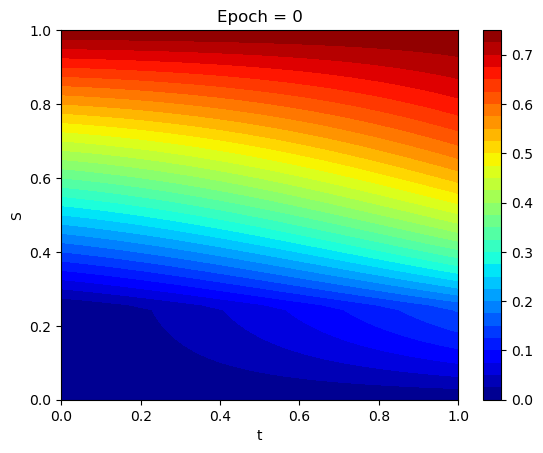

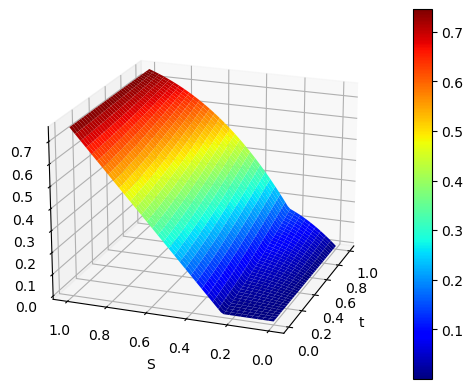

In [133]:
net.plot()

Epoch: 1000, loss: 9.951925221685087e-07


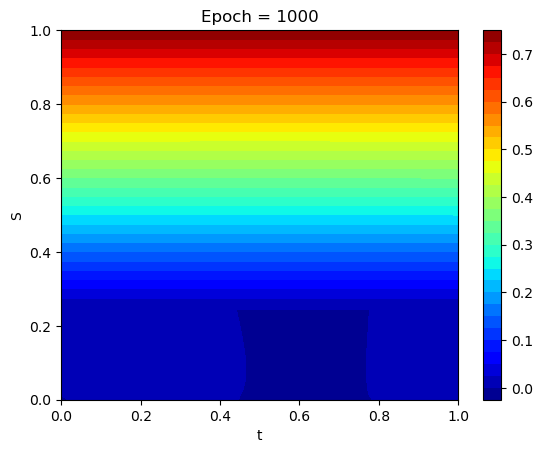

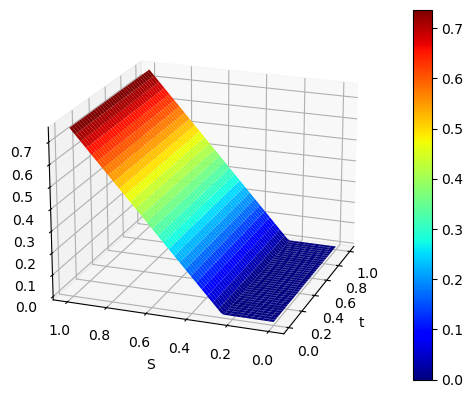

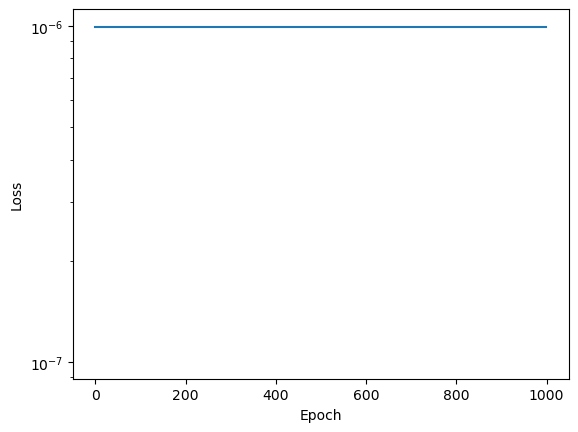

In [134]:
# epochs = int(500)
# lr = 1e-4
# net.train(XGPU,epochs,lr)

# epochs = int(3000)
# lr = 1e-7
# net.train(XGPU,epochs,lr)

epochs=int(1000)
net.train2(XGPU,epochs)